In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

from utils.plots import plot_class_distribution

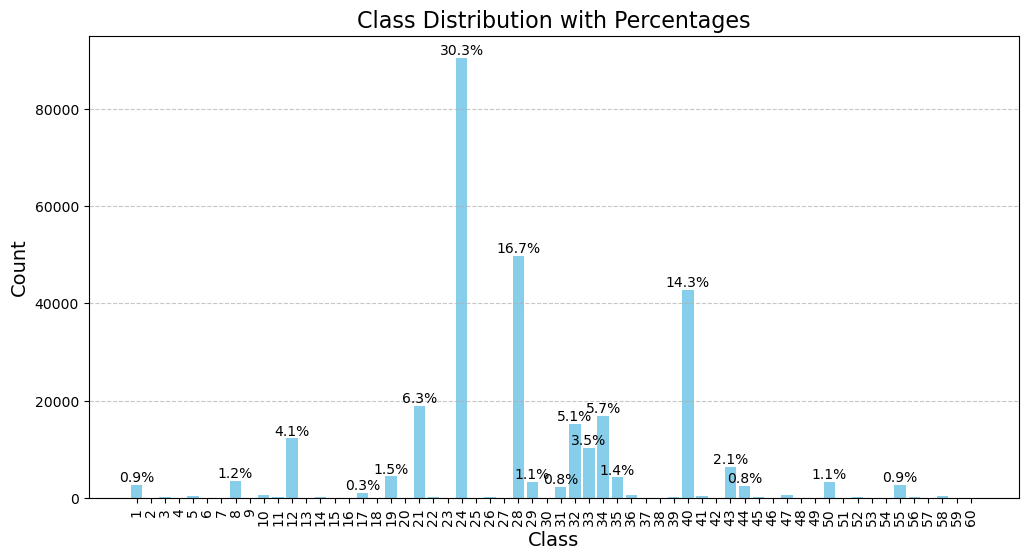

In [5]:
with open('../data/land_cover_representation/metadata.csv') as f:
    metadata = pd.read_csv(f)

classes = pd.unique(metadata['land_cover'])
class_distribution = pd.Series(metadata['land_cover']).value_counts()
classes_dict = pd.Series.to_dict(class_distribution)

class_doc = dict(zip(pd.unique(metadata['y']), pd.unique(metadata['land_cover'])))
class_doc = dict(sorted(class_doc.items()))

class_count = {}
for i in range(1, 61):
    class_count[i] = (class_doc[i], classes_dict[class_doc[i]])

count_df = pd.DataFrame.from_dict(class_count, orient='index', columns=['land_cover', 'count'])

plot_class_distribution(count_df)

,land_cover,count
0,Cotton,2754
1,Winter Wheat,3485
2,Alfalfa,12274
3,Tomatoes,4443
4,Fallow/Idle Cropland,18897
5,Grapes,90484
6,Almonds,49792
7,Walnuts,3299
8,Open Water,2320
9,Developed/Open Space,15231


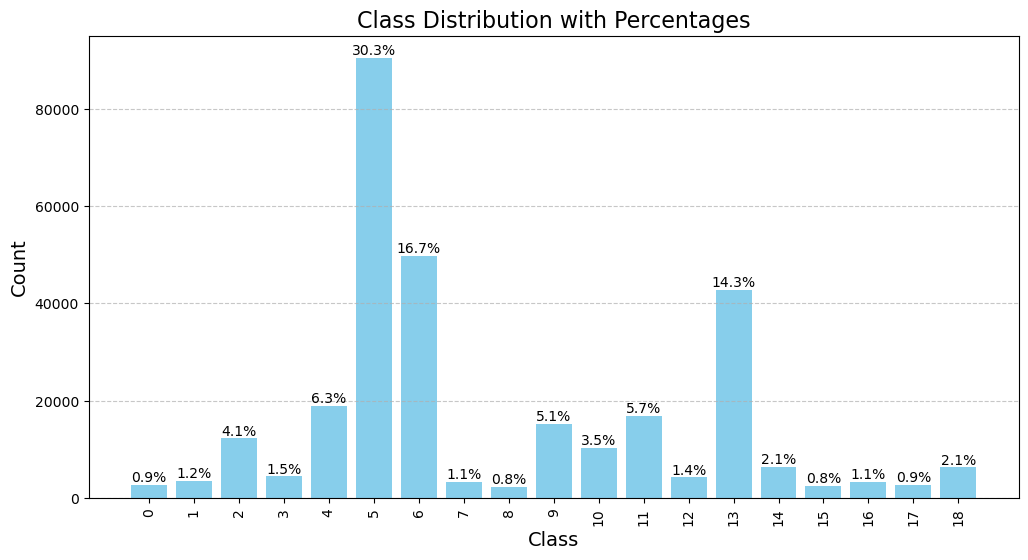

In [6]:
min_count = 2000

low_counts_df = count_df[count_df['count'] < min_count]
new_count_df = count_df[count_df['count'] >= min_count].reset_index(drop=True)
new_count_df.loc[len(new_count_df)] = ['Other', sum(low_counts_df['count'])]
display(new_count_df)

plot_class_distribution(new_count_df)

In [7]:
# Map low-count classes to 'Other'
low_count_classes = set(low_counts_df['land_cover'])
metadata['land_cover'] = metadata['land_cover'].apply(lambda x: 'Other' if x in low_count_classes else x)

# Create a mapping for the new 'y' values based on the index of new_count_df
land_cover_to_y = {land_cover: idx for idx, (land_cover, _) in new_count_df.iterrows()}
metadata['y'] = metadata['land_cover'].map(land_cover_to_y)

# Recalculate class distribution for the new metadata
new_class_distribution = metadata['land_cover'].value_counts()

display(metadata[metadata['land_cover'] == 'Other'])

,file_name,y,split,split_str,land_cover
17,tiles/5distant.npy,18.0,0,train,Other
48,tiles/16anchor.npy,18.0,0,train,Other
49,tiles/16neighbor.npy,18.0,0,train,Other
53,tiles/17distant.npy,18.0,0,train,Other
183,tiles/61anchor.npy,18.0,0,train,Other
...,...,...,...,...,...
299764,tiles/99921neighbor.npy,18.0,0,train,Other
299811,tiles/99937anchor.npy,18.0,0,train,Other
299812,tiles/99937neighbor.npy,18.0,0,train,Other
299925,tiles/99975anchor.npy,18.0,0,train,Other


In [9]:
# Separate data by land_cover classes
balanced_metadata = pd.DataFrame()
for cls in new_class_distribution.index:
    class_data = metadata[metadata['land_cover'] == cls]
    train, temp = train_test_split(class_data, test_size=0.2, random_state=42, stratify=class_data['land_cover'])
    val, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['land_cover'])
    
    train['split_str'] = 'train'
    val['split_str'] = 'val'
    test['split_str'] = 'test'
    
    balanced_metadata = pd.concat([balanced_metadata, train, val, test])

# Ensure the headers and structure match the original metadata file
balanced_metadata = balanced_metadata[['file_name', 'y', 'split', 'split_str', 'land_cover']]
balanced_metadata = balanced_metadata.set_index('file_name').reindex(metadata['file_name']).reset_index()

# Save the new metadata to a CSV file
save_path = '../data/land_cover_representation/metadata_balanced.csv'
balanced_metadata.to_csv(save_path, index=False)

print(f"Balanced metadata file saved at {save_path}")

Balanced metadata file saved at ../data/land_cover_representation/metadata_balanced.csv
